# SVM Analysis: Students Social Media Addiction
#### Raymond Feivel Liander - 5025231214

## Objective
Untuk memprediksi "Addicted Score" siswa terhadap media sosial berdasarkan perilaku karakteristik mereka menggunakan algoritma SVM.

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression

## Load and Explore Dataset

In [5]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("--- Memuat dan Mengeksplorasi Dataset ---")
print("=" * 50)

# Load the preprocessed data
df = pd.read_csv('../dataset/Students_Social_Media_Addiction_Feature_Engineered.csv')
print("Preprocessed data loaded successfully.")
print(f"Shape of preprocessed data: {df.shape}")

df.head()

--- Memuat dan Mengeksplorasi Dataset ---
Preprocessed data loaded successfully.
Shape of preprocessed data: (705, 25)


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,...,Academic_Level_Encoded,Relationship_Status_Encoded,SM_Impact_Score,Lifestyle_Balance,Usage_Category_Medium,Usage_Category_High,Usage_Category_Very High,Mental_Health_Risk_Medium,Mental_Health_Risk_Low,Mental_Health_Risk_Very Low
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,...,2,1,5.2,1.3,False,True,False,True,False,False
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,...,0,2,0.0,5.4,True,False,False,False,True,False
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,...,2,0,6.0,-1.0,False,True,False,True,False,False
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,...,1,2,0.0,4.0,True,False,False,False,True,False
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,...,0,1,4.5,1.5,False,True,False,True,False,False


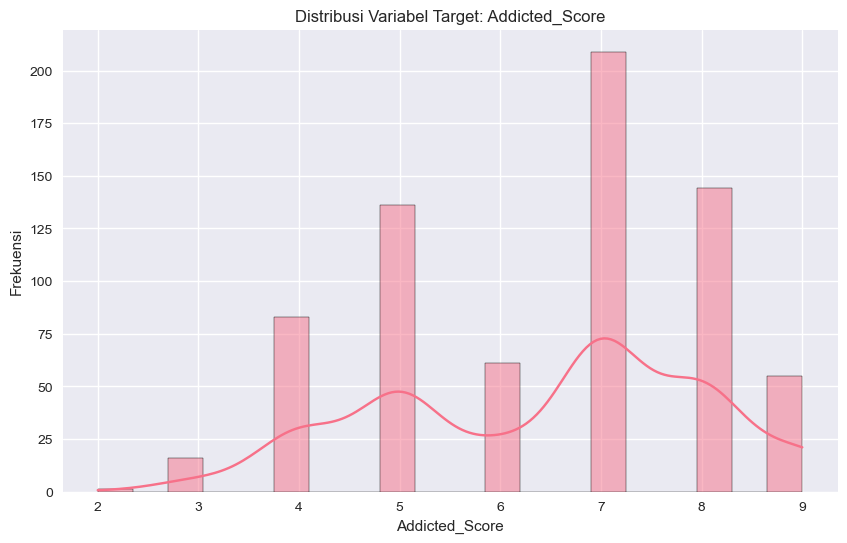

In [6]:
# Define target variable 
target_column = 'Addicted_Score'
y = df[target_column]

# Plot distribusi variabel target
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=20)
plt.title(f'Distribusi Variabel Target: {target_column}')
plt.xlabel(target_column)
plt.ylabel('Frekuensi')
plt.show()

## Menghapus Kolom Non-Numerik

In [8]:
# --- Membersihkan Data: Menghapus Kolom Non-Numerik ---
print("\n--- Membersihkan Data: Menghapus Kolom Non-Numerik ---")
print("=" * 65)

# Kolom yang akan dihapus karena non-numerik atau tidak relevan sebagai fitur
columns_to_drop_from_features = [
    'Student_ID',
    'Gender',
    'Academic_Level',
    'Country',
    'Most_Used_Platform',
    'Affects_Academic_Performance',
    'Relationship_Status'
]

# Buat DataFrame fitur yang hanya berisi kolom numerik yang relevan.
# Kolom target juga akan dikeluarkan untuk membentuk X_all.
X_all = df.drop(columns=columns_to_drop_from_features + [target_column], errors='ignore')

print(f"Kolom yang dihapus: {columns_to_drop_from_features} dan '{target_column}' (dari X_all)")


--- Membersihkan Data: Menghapus Kolom Non-Numerik ---
Kolom yang dihapus: ['Student_ID', 'Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status'] dan 'Addicted_Score' (dari X_all)


## Skenario Uji Coba 1: Selected Feature


--- Uji Coba 1: Perbandingan 'Selected Feature' (Menggunakan SVR) ---
  k= 1 fitur: R² = 0.8748
  k= 2 fitur: R² = 0.9432
  k= 3 fitur: R² = 0.9495
  k= 4 fitur: R² = 0.9516
  k= 5 fitur: R² = 0.9557
  k= 6 fitur: R² = 0.9552
  k= 7 fitur: R² = 0.9554
  k= 8 fitur: R² = 0.9546
  k= 9 fitur: R² = 0.9541
  k=10 fitur: R² = 0.9535
  k=11 fitur: R² = 0.9533
  k=12 fitur: R² = 0.9476
  k=13 fitur: R² = 0.9480
  k=14 fitur: R² = 0.9479
  k=15 fitur: R² = 0.9479
  k=16 fitur: R² = 0.9481
  k=17 fitur: R² = 0.9477

Jumlah fitur optimal (k) yang ditemukan: 5 dengan R² = 0.9557


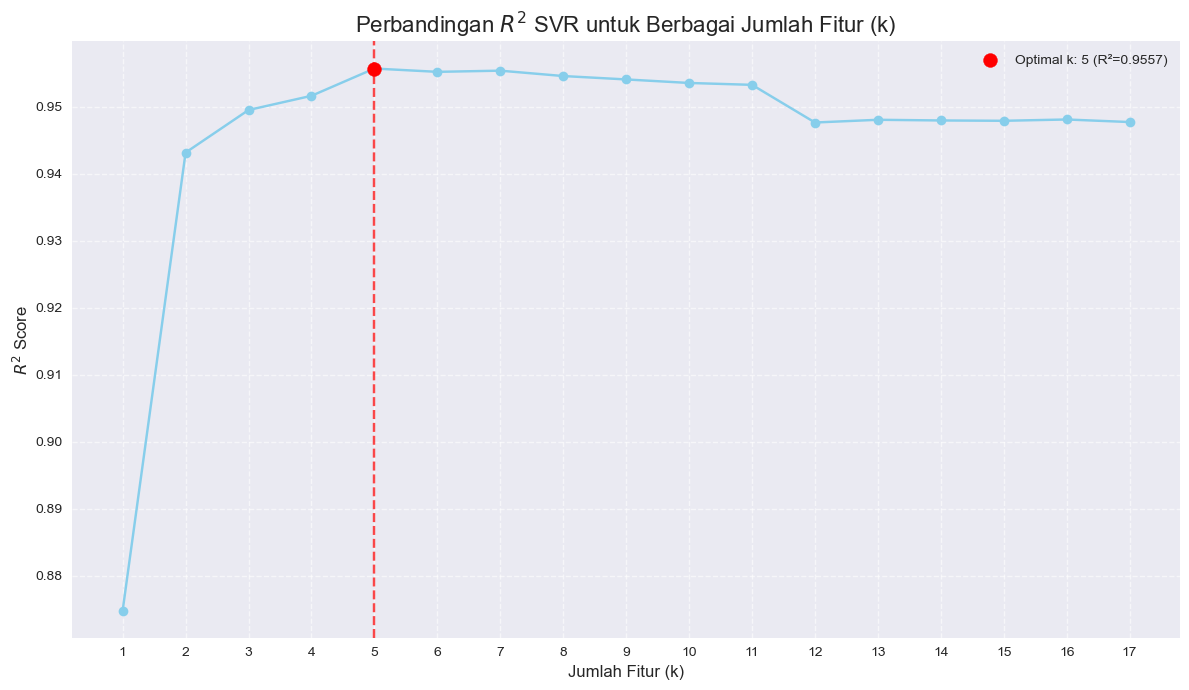


--- Fitur Optimal Telah Terpilih dan Akan Digunakan untuk Perbandingan ---
Jumlah fitur yang akan digunakan: 5
Daftar fitur terpilih:
  1. Mental_Health_Score
  2. Conflicts_Over_Social_Media
  3. SM_Impact_Score
  4. Lifestyle_Balance
  5. Mental_Health_Risk_Low


In [10]:
# --- Uji Coba 1: Perbandingan "Selected Feature" (Menggunakan SVR) ---
print("\n--- Uji Coba 1: Perbandingan 'Selected Feature' (Menggunakan SVR) ---")
print("=" * 65)

# Split data into training and testing sets (X_all sebagai dasar)
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Daftar nilai k yang akan diuji (dari 1 fitur hingga semua fitur)
k_values_to_test = [k for k in range(1, X_all.shape[1] + 1)]

# Dictionary untuk menyimpan R^2 score untuk setiap nilai k
r2_scores_per_k = {}

for k in k_values_to_test:
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_train_all, y_train) # Fit pada data training
    X_train_selected_k = selector.transform(X_train_all)
    X_test_selected_k = selector.transform(X_test_all)

    svr_model_temp = SVR() # Model SVR default untuk evaluasi k
    svr_model_temp.fit(X_train_selected_k, y_train)
    y_pred_k = svr_model_temp.predict(X_test_selected_k)
    r2_k = r2_score(y_test, y_pred_k)
    r2_scores_per_k[k] = r2_k
    print(f"  k={k:2d} fitur: R² = {r2_k:.4f}")

# Temukan nilai k yang memberikan R^2 tertinggi
optimal_k = max(r2_scores_per_k, key=r2_scores_per_k.get)
best_r2_for_optimal_k = r2_scores_per_k[optimal_k]

print(f"\nJumlah fitur optimal (k) yang ditemukan: {optimal_k} dengan R² = {best_r2_for_optimal_k:.4f}")

# Membuat grafik R^2 
plt.figure(figsize=(12, 7))
plt.plot(list(r2_scores_per_k.keys()), list(r2_scores_per_k.values()), marker='o', linestyle='-', color='skyblue')
plt.title('Perbandingan $R^2$ SVR untuk Berbagai Jumlah Fitur (k)', fontsize=16)
plt.xlabel('Jumlah Fitur (k)', fontsize=12)
plt.ylabel('$R^2$ Score', fontsize=12)
plt.xticks(list(r2_scores_per_k.keys()))
plt.grid(True, linestyle='--', alpha=0.6)

# Tandai k optimal
plt.scatter(optimal_k, best_r2_for_optimal_k, color='red', s=100, zorder=5, label=f'Optimal k: {optimal_k} (R²={best_r2_for_optimal_k:.4f})')
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Mendapatkan fitur yang dipilih oleh SelectKBest dengan optimal_k
final_selector_optimal = SelectKBest(score_func=f_regression, k=optimal_k)
final_selector_optimal.fit(X_train_all, y_train) # Fit lagi dengan k optimal
features_selected_by_kbest_optimal = X_all.columns[final_selector_optimal.get_support()].tolist()

print("\n--- Fitur Optimal Telah Terpilih dan Akan Digunakan untuk Perbandingan ---")
print(f"Jumlah fitur yang akan digunakan: {optimal_k}")
print("Daftar fitur terpilih:")
for i, feature in enumerate(features_selected_by_kbest_optimal, 1):
    print(f"  {i}. {feature}")


1. Melatih dan mengevaluasi SVR dengan SEMUA FITUR ...
   R² Score: 0.9477
   MAE: 0.2472
   RMSE: 0.3617

2. Melatih dan mengevaluasi SVR dengan FITUR TERPILIH (dari SelectKBest)...
   R² Score: 0.9557
   MAE: 0.2014
   RMSE: 0.3330


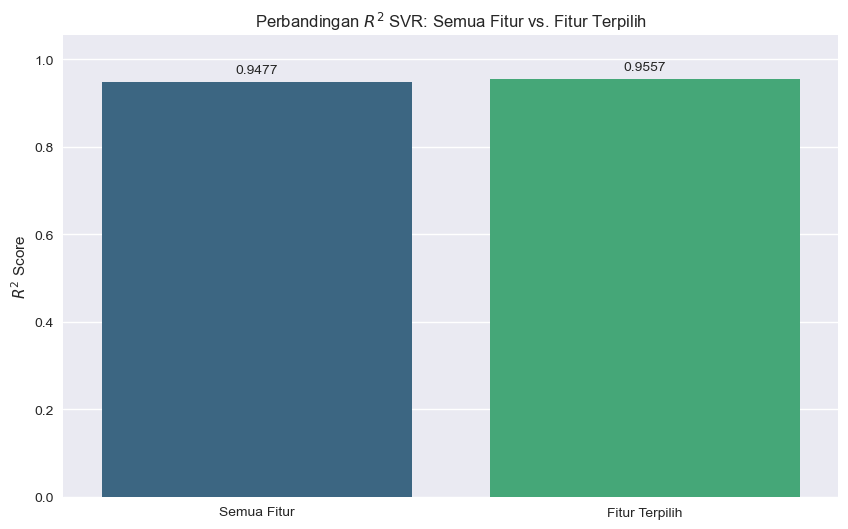


--- Ringkasan Hasil Uji Coba 1 ---

Skenario Fitur       R² Score     MAE        RMSE       Jumlah Fitur   
----------------------------------------------------------------------
Semua Fitur          0.9477       0.2472     0.3617     17             
Fitur Terpilih       0.9557       0.2014     0.3330     5              

KESIMPULAN UJI COBA 1: Untuk Uji Coba 2, kita akan menggunakan 'Fitur Terpilih' karena memberikan R² yang lebih tinggi.


In [11]:
# Sekarang, gunakan fitur yang ditemukan oleh SelectKBest untuk X_selected
X_selected = X_all[features_selected_by_kbest_optimal]

# Split data for selected features (berdasarkan X_selected yang baru)
X_train_selected, X_test_selected, _, _ = train_test_split(X_selected, y, test_size=0.2, random_state=42) # y_train dan y_test sama

# Dictionary untuk menyimpan hasil
results_uc1 = {}

# Inisialisasi model SVR (menggunakan parameter default)
svr_model_all = SVR()
svr_model_selected = SVR()

# Latih dan evaluasi model dengan SEMUA FITUR (yang sudah numerik)
print("\n1. Melatih dan mengevaluasi SVR dengan SEMUA FITUR ...")
svr_model_all.fit(X_train_all, y_train)
y_pred_all = svr_model_all.predict(X_test_all)
r2_all_features = r2_score(y_test, y_pred_all)
mae_all_features = mean_absolute_error(y_test, y_pred_all)
rmse_all_features = np.sqrt(mean_squared_error(y_test, y_pred_all))
results_uc1['Semua Fitur'] = {'R2': r2_all_features, 'MAE': mae_all_features, 'RMSE': rmse_all_features, 'n_features': X_train_all.shape[1]}
print(f"   R² Score: {r2_all_features:.4f}")
print(f"   MAE: {mae_all_features:.4f}")
print(f"   RMSE: {rmse_all_features:.4f}")

# Latih dan evaluasi model dengan FITUR TERPILIH (dari SelectKBest)
print("\n2. Melatih dan mengevaluasi SVR dengan FITUR TERPILIH (dari SelectKBest)...")
svr_model_selected.fit(X_train_selected, y_train)
y_pred_selected = svr_model_selected.predict(X_test_selected)
r2_selected_features = r2_score(y_test, y_pred_selected)
mae_selected_features = mean_absolute_error(y_test, y_pred_selected)
rmse_selected_features = np.sqrt(mean_squared_error(y_test, y_pred_selected))
results_uc1['Fitur Terpilih'] = {'R2': r2_selected_features, 'MAE': mae_selected_features, 'RMSE': rmse_selected_features, 'n_features': X_train_selected.shape[1]}
print(f"   R² Score: {r2_selected_features:.4f}")
print(f"   MAE: {mae_selected_features:.4f}")
print(f"   RMSE: {rmse_selected_features:.4f}")

# Plotting R^2 comparison for Uji Coba 1
plt.figure(figsize=(10, 6))
r2_scores_uc1 = {k: v['R2'] for k, v in results_uc1.items()}
sns.barplot(x=list(r2_scores_uc1.keys()), y=list(r2_scores_uc1.values()), hue=list(r2_scores_uc1.keys()), palette='viridis', legend=False)
plt.title('Perbandingan $R^2$ SVR: Semua Fitur vs. Fitur Terpilih')
plt.ylabel('$R^2$ Score')
plt.ylim(min(0, min(r2_scores_uc1.values()) - 0.1), max(1, max(r2_scores_uc1.values()) + 0.1))
for index, value in enumerate(list(r2_scores_uc1.values())):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center')
plt.show()

# Ringkasan Hasil Uji Coba 1
print("\n--- Ringkasan Hasil Uji Coba 1 ---")
print(f"\n{'Skenario Fitur':<20} {'R² Score':<12} {'MAE':<10} {'RMSE':<10} {'Jumlah Fitur':<15}")
print("-" * 70)
for scenario, metrics in results_uc1.items():
    print(f"{scenario:<20} {metrics['R2']:<12.4f} {metrics['MAE']:<10.4f} {metrics['RMSE']:<10.4f} {metrics['n_features']:<15}")

# Tentukan set fitur mana yang berkinerja lebih baik untuk uji coba berikutnya
best_features_scenario_uc1 = 'Fitur Terpilih' if r2_selected_features >= r2_all_features else 'Semua Fitur'
X_for_uc2 = X_selected.copy() if r2_selected_features >= r2_all_features else X_all.copy()

print(f"\nKESIMPULAN UJI COBA 1: Untuk Uji Coba 2, kita akan menggunakan '{best_features_scenario_uc1}' karena memberikan R² yang lebih tinggi.")

## Skenario Uji Coba 2: Normalisasi Data


--- Uji Coba 2: Perbandingan Normalisasi Data ---

1. Melatih dan mengevaluasi SVR TANPA NORMALISASI...
   R² Score: 0.9557
   MAE: 0.2014
   RMSE: 0.3330

2. Melatih dan mengevaluasi SVR DENGAN NORMALISASI ...
   R² Score: 0.9270
   MAE: 0.1911
   RMSE: 0.4274


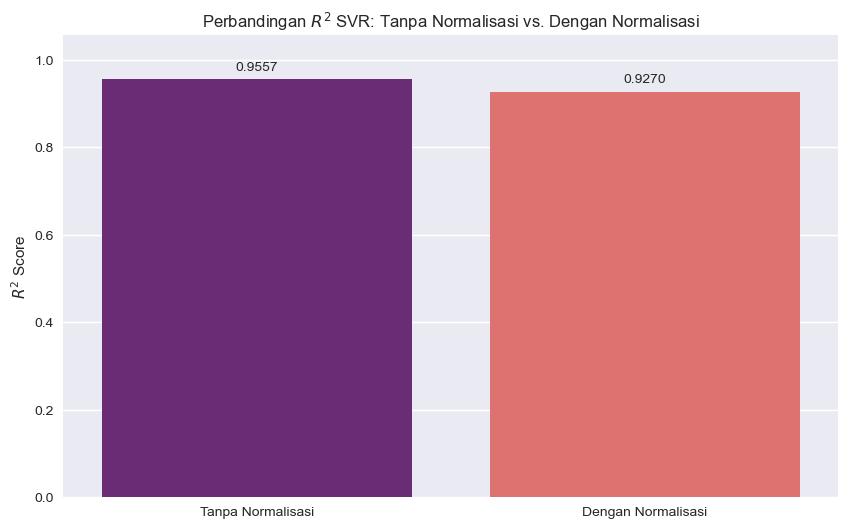


--- Ringkasan Hasil Uji Coba 2 ---

Skenario Normalisasi      R² Score     MAE        RMSE      
-----------------------------------------------------------------
Tanpa Normalisasi         0.9557       0.2014     0.3330    
Dengan Normalisasi        0.9270       0.1911     0.4274    

KESIMPULAN UJI COBA 2: Untuk Uji Coba 3 (Parameter Tuning), kita akan menggunakan data 'Tanpa Normalisasi' karena memberikan R² yang lebih tinggi.


In [13]:
print("\n--- Uji Coba 2: Perbandingan Normalisasi Data ---")
print("=" * 65)

# Split data for Uji Coba 2 (menggunakan X_for_uc2 yang sudah ditentukan)
X_train_uc2, X_test_uc2, y_train_uc2, y_test_uc2 = train_test_split(X_for_uc2, y, test_size=0.2, random_state=42)

# Dictionary untuk menyimpan hasil Uji Coba 2
results_uc2 = {}

# --- Skenario 1: Tanpa Normalisasi ---
print("\n1. Melatih dan mengevaluasi SVR TANPA NORMALISASI...")
svr_unnormalized = SVR()
svr_unnormalized.fit(X_train_uc2, y_train_uc2)
y_pred_unnormalized = svr_unnormalized.predict(X_test_uc2)

r2_unnormalized = r2_score(y_test_uc2, y_pred_unnormalized)
mae_unnormalized = mean_absolute_error(y_test_uc2, y_pred_unnormalized)
rmse_unnormalized = np.sqrt(mean_squared_error(y_test_uc2, y_pred_unnormalized))

results_uc2['Tanpa Normalisasi'] = {
    'R2': r2_unnormalized,
    'MAE': mae_unnormalized,
    'RMSE': rmse_unnormalized
}
print(f"   R² Score: {r2_unnormalized:.4f}")
print(f"   MAE: {mae_unnormalized:.4f}")
print(f"   RMSE: {rmse_unnormalized:.4f}")

# --- Skenario 2: Dengan Normalisasi (StandardScaler) ---
print("\n2. Melatih dan mengevaluasi SVR DENGAN NORMALISASI ...")

scaler = StandardScaler()
X_train_scaled_uc2 = scaler.fit_transform(X_train_uc2)
X_test_scaled_uc2 = scaler.transform(X_test_uc2)

svr_normalized = SVR()
svr_normalized.fit(X_train_scaled_uc2, y_train_uc2)
y_pred_normalized = svr_normalized.predict(X_test_scaled_uc2)

r2_normalized = r2_score(y_test_uc2, y_pred_normalized)
mae_normalized = mean_absolute_error(y_test_uc2, y_pred_normalized)
rmse_normalized = np.sqrt(mean_squared_error(y_test_uc2, y_pred_normalized))

results_uc2['Dengan Normalisasi'] = {
    'R2': r2_normalized,
    'MAE': mae_normalized,
    'RMSE': rmse_normalized
}
print(f"   R² Score: {r2_normalized:.4f}")
print(f"   MAE: {mae_normalized:.4f}")
print(f"   RMSE: {rmse_normalized:.4f}")

# Plotting R^2 comparison for Uji Coba 2
plt.figure(figsize=(10, 6))
r2_scores_uc2 = {k: v['R2'] for k, v in results_uc2.items()}
sns.barplot(x=list(r2_scores_uc2.keys()), y=list(r2_scores_uc2.values()), hue=list(r2_scores_uc2.keys()), palette='magma', legend=False)
plt.title('Perbandingan $R^2$ SVR: Tanpa Normalisasi vs. Dengan Normalisasi')
plt.ylabel('$R^2$ Score')
plt.ylim(min(0, min(r2_scores_uc2.values()) - 0.1), max(1, max(r2_scores_uc2.values()) + 0.1))
for index, value in enumerate(list(r2_scores_uc2.values())):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center')
plt.show()

# Ringkasan Hasil Uji Coba 2
print("\n--- Ringkasan Hasil Uji Coba 2 ---")
print(f"\n{'Skenario Normalisasi':<25} {'R² Score':<12} {'MAE':<10} {'RMSE':<10}")
print("-" * 65)
for scenario, metrics in results_uc2.items():
    print(f"{scenario:<25} {metrics['R2']:<12.4f} {metrics['MAE']:<10.4f} {metrics['RMSE']:<10.4f}")

# Tentukan data mana yang berkinerja lebih baik untuk uji coba berikutnya
if r2_normalized >= r2_unnormalized:
    best_normalization_scenario_uc2 = 'Dengan Normalisasi'
    # Simpan X yang sudah di-scale untuk Uji Coba 3
    X_for_uc3_train, X_for_uc3_test = X_train_scaled_uc2, X_test_scaled_uc2
    print(f"\nKESIMPULAN UJI COBA 2: Untuk Uji Coba 3 (Parameter Tuning), kita akan menggunakan data '{best_normalization_scenario_uc2}' karena memberikan $R^2$ yang lebih tinggi atau sama.")
else:
    best_normalization_scenario_uc2 = 'Tanpa Normalisasi'
    # Simpan X yang tidak di-scale untuk Uji Coba 3
    X_for_uc3_train, X_for_uc3_test = X_train_uc2, X_test_uc2
    print(f"\nKESIMPULAN UJI COBA 2: Untuk Uji Coba 3 (Parameter Tuning), kita akan menggunakan data '{best_normalization_scenario_uc2}' karena memberikan R² yang lebih tinggi.")


## Skenario Uji Coba 3: Parameter Tuning


--- Uji Coba 3: Parameter Tuning (Perbandingan Kernel) ---

Melatih dan mengevaluasi SVR dengan Kernel: 'linear'
----------------------------------------------
   R² Score: 0.9450
   MAE: 0.2467
   RMSE: 0.3711

Melatih dan mengevaluasi SVR dengan Kernel: 'poly'
--------------------------------------------
   R² Score: 0.9609
   MAE: 0.1831
   RMSE: 0.3128

Melatih dan mengevaluasi SVR dengan Kernel: 'rbf'
-------------------------------------------
   R² Score: 0.9557
   MAE: 0.2014
   RMSE: 0.3330


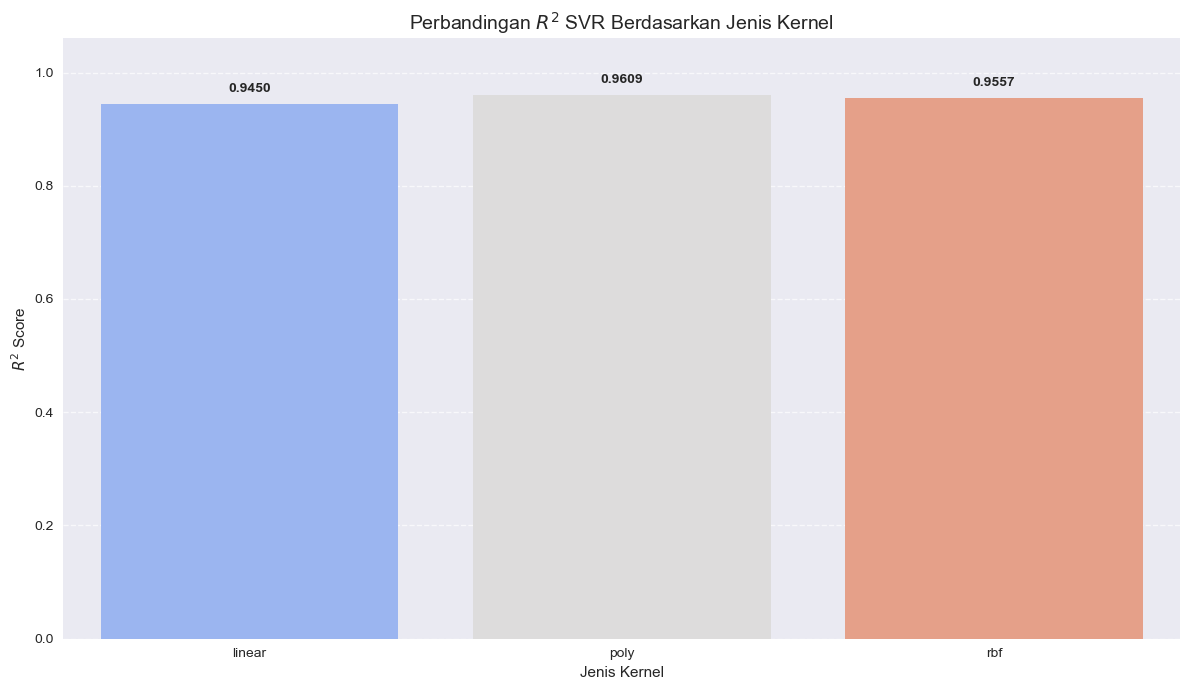


--- Ringkasan Hasil Uji Coba 3 (Perbandingan Kernel) ---

Jenis Kernel    R² Score     MAE        RMSE      
--------------------------------------------------
linear          0.9450       0.2467     0.3711    
poly            0.9609       0.1831     0.3128    
rbf             0.9557       0.2014     0.3330    

KESIMPULAN AKHIR: Kernel terbaik adalah 'poly' dengan R² Score: 0.9609


In [15]:
print("\n--- Uji Coba 3: Parameter Tuning (Perbandingan Kernel) ---")
print("=" * 70)

# Daftar kernel yang akan diuji
kernels_to_test = ['linear', 'poly', 'rbf']

# Dictionary untuk menyimpan hasil Uji Coba 3
results_uc3 = {}

# Loop melalui setiap kernel dan latih/evaluasi model SVR
for kernel in kernels_to_test:
    print(f"\nMelatih dan mengevaluasi SVR dengan Kernel: '{kernel}'")
    print("-" * (40 + len(kernel)))
    
    svr_model = SVR(kernel=kernel)

    # Latih model
    svr_model.fit(X_for_uc3_train, y_train_uc2)

    # Buat prediksi
    y_pred = svr_model.predict(X_for_uc3_test)

    # Hitung metrik
    r2 = r2_score(y_test_uc2, y_pred)
    mae = mean_absolute_error(y_test_uc2, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_uc2, y_pred))

    results_uc3[kernel] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }

    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")

# Plotting R^2 comparison for Uji Coba 3 (Kernels)
plt.figure(figsize=(12, 7))
r2_scores_uc3 = {k: v['R2'] for k, v in results_uc3.items()}
sns.barplot(x=list(r2_scores_uc3.keys()), y=list(r2_scores_uc3.values()), hue=list(r2_scores_uc3.keys()), palette='coolwarm', legend=False)
plt.title('Perbandingan $R^2$ SVR Berdasarkan Jenis Kernel', fontsize=14)
plt.xlabel('Jenis Kernel')
plt.ylabel('$R^2$ Score')
plt.ylim(min(0, min(r2_scores_uc3.values()) - 0.1), max(1, max(r2_scores_uc3.values()) + 0.1))
for index, value in enumerate(list(r2_scores_uc3.values())):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Ringkasan Hasil Uji Coba 3
print("\n--- Ringkasan Hasil Uji Coba 3 (Perbandingan Kernel) ---")
print(f"\n{'Jenis Kernel':<15} {'R² Score':<12} {'MAE':<10} {'RMSE':<10}")
print("-" * 50)
best_kernel_r2 = -np.inf
best_kernel_name = ""

for kernel, metrics in results_uc3.items():
    r2, mae, rmse = metrics['R2'], metrics['MAE'], metrics['RMSE']
    if r2 > best_kernel_r2:
        best_kernel_r2 = r2
        best_kernel_name = kernel
    print(f"{kernel:<15} {r2:<12.4f} {mae:<10.4f} {rmse:<10.4f}")

print(f"\nKESIMPULAN AKHIR: Kernel terbaik adalah '{best_kernel_name}' dengan R² Score: {best_kernel_r2:.4f}")

In [16]:
print("\n--- Uji Coba 3 (Lanjutan): Parameter Tuning (Menggunakan RandomizedSearchCV) ---")
print("=" * 80)

# Definisikan kernel terbaik yang ditemukan dari Uji Coba 3
best_kernel = best_kernel_name 

print(f"Melakukan tuning parameter untuk Kernel terbaik: '{best_kernel}'")

# Inisialisasi model SVR dengan kernel terbaik
svr = SVR(kernel=best_kernel)

# Definisikan grid parameter yang akan diuji
# RandomizedSearchCV akan memilih subset acak dari kombinasi ini
param_grid_random = {
    'C': [0.1, 1],        # Rentang C
    'epsilon': [0.05, 0.1, 0.2], # Rentang epsilon
    'degree': [2, 3, 4],             # Rentang degree
    'gamma': ['scale', 0.01, 0.1, 1] # Rentang gamma
}

# Inisialisasi RandomizedSearchCV
# n_iter: jumlah kombinasi parameter yang akan diuji secara acak (misal, 20)
# cv: jumlah fold untuk cross-validation (misal, 3)
random_search = RandomizedSearchCV(estimator=svr,
                                   param_distributions=param_grid_random,
                                   n_iter=20,       # 20 kombinasi acak untuk kecepatan
                                   scoring='r2',
                                   cv=3,            # 3-fold cross-validation
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42) # Penting untuk reproduksibilitas

print(f"\nMencari kombinasi parameter terbaik dengan RandomizedSearchCV (n_iter={random_search.n_iter}, cv={random_search.cv})...")
print(f"Grid Parameter yang diuji: {param_grid_random}")

# Lakukan pencarian acak pada data pelatihan terbaik
random_search.fit(X_for_uc3_train, y_train_uc2)

print("\n--- Hasil RandomizedSearchCV ---")
print("=" * 30)

# Dapatkan parameter terbaik dan skor terbaik
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Parameter terbaik ditemukan: {best_params}")
print(f"R² Score terbaik pada Cross-Validation: {best_score:.4f}")

# Evaluasi model terbaik pada test set
print("\n--- Evaluasi Model SVR Terbaik pada Test Set (RandomizedSearchCV) ---")
print("=" * 65)

best_svr_model_tuned = random_search.best_estimator_
y_pred_tuned = best_svr_model_tuned.predict(X_for_uc3_test)

r2_tuned = r2_score(y_test_uc2, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test_uc2, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test_uc2, y_pred_tuned))

print(f"R² Score (Tuned Model) pada Test Set: {r2_tuned:.4f}")
print(f"MAE (Tuned Model) pada Test Set: {mae_tuned:.4f}")
print(f"RMSE (Tuned Model) pada Test Set: {rmse_tuned:.4f}")

if 'poly' in results_uc3:
    r2_poly_default = results_uc3['poly']['R2']
    print(f"\nPerbandingan dengan Kernel 'poly' (Default Parameters):")
    print(f"  R² Score (Poly Default): {r2_poly_default:.4f}")
    if r2_tuned > r2_poly_default:
        print(f"  Peningkatan R² setelah tuning: {(r2_tuned - r2_poly_default):.4f}")
    else:
        print(f"  Tidak ada peningkatan R² signifikan setelah tuning. Performa default sudah baik.")

print("\nUji Coba 3 (Parameter Tuning dengan RandomizedSearchCV) Selesai.")
print("Model SVR yang sudah di-tuning telah ditemukan.")


--- Uji Coba 3 (Lanjutan): Parameter Tuning (Menggunakan RandomizedSearchCV) ---
Melakukan tuning parameter untuk Kernel terbaik: 'poly'

Mencari kombinasi parameter terbaik dengan RandomizedSearchCV (n_iter=20, cv=3)...
Grid Parameter yang diuji: {'C': [0.1, 1], 'epsilon': [0.05, 0.1, 0.2], 'degree': [2, 3, 4], 'gamma': ['scale', 0.01, 0.1, 1]}
Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- Hasil RandomizedSearchCV ---
Parameter terbaik ditemukan: {'gamma': 0.1, 'epsilon': 0.1, 'degree': 3, 'C': 1}
R² Score terbaik pada Cross-Validation: 0.9532

--- Evaluasi Model SVR Terbaik pada Test Set (RandomizedSearchCV) ---
R² Score (Tuned Model) pada Test Set: 0.9524
MAE (Tuned Model) pada Test Set: 0.1953
RMSE (Tuned Model) pada Test Set: 0.3453

Perbandingan dengan Kernel 'poly' (Default Parameters):
  R² Score (Poly Default): 0.9609
  Tidak ada peningkatan R² signifikan setelah tuning. Performa default sudah baik.

Uji Coba 3 (Parameter Tuning dengan RandomizedSearchCV) 


--- Perbandingan R² Kernel 'poly' (Default vs. Tuned) ---


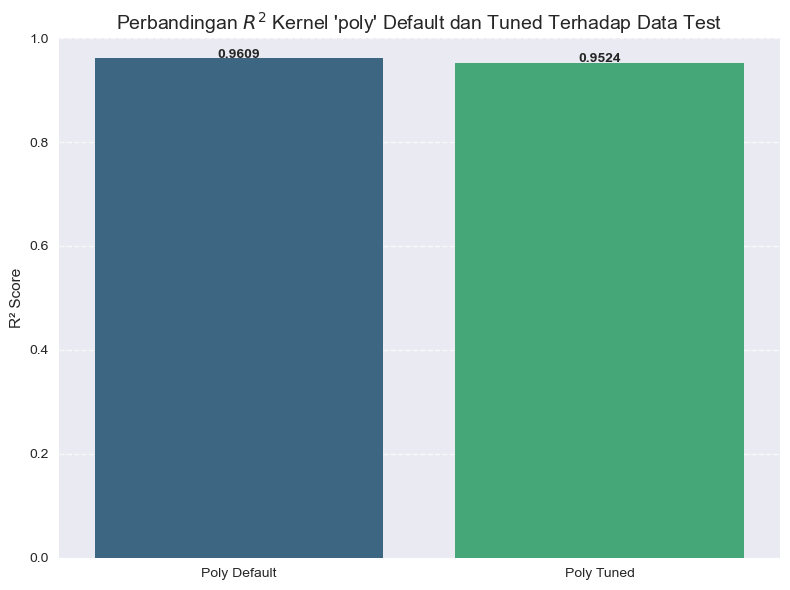


Analisis Perbandingan:
- R² Kernel 'poly' Default: 0.9609
- R² Kernel 'poly' Tuned: 0.9524
  Model yang di-tuning menunjukkan penurunan (R² lebih rendah) dibandingkan model default.


In [17]:
print("\n--- Perbandingan R² Kernel 'poly' (Default vs. Tuned) ---")
print("=" * 70)

r2_poly_default = results_uc3['poly']['R2']

comparison_r2_scores = {
    'Poly Default': r2_poly_default,
    'Poly Tuned': r2_tuned
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(comparison_r2_scores.keys()), y=list(comparison_r2_scores.values()),
            hue=list(comparison_r2_scores.keys()), palette='viridis', legend=False)
plt.title('Perbandingan $R^2$ Kernel \'poly\' Default dan Tuned Terhadap Data Test', fontsize=14)
plt.ylabel('R² Score')
plt.ylim(min(0, min(comparison_r2_scores.values()) - 0.01), max(1, max(comparison_r2_scores.values()) + 0.01)) # Sesuaikan ylim
for index, value in enumerate(list(comparison_r2_scores.values())):
    plt.text(index, value + 0.001, f'{value:.4f}', ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nAnalisis Perbandingan:")
print(f"- R² Kernel 'poly' Default: {r2_poly_default:.4f}")
print(f"- R² Kernel 'poly' Tuned: {r2_tuned:.4f}")
if r2_tuned > r2_poly_default:
    print(f"  Model yang di-tuning menunjukkan peningkatan (R² lebih tinggi) dibandingkan model default.")
elif r2_tuned == r2_poly_default:
    print(f"  Performa model yang di-tuning sama persis dengan model default.")
else:
    print(f"  Model yang di-tuning menunjukkan penurunan (R² lebih rendah) dibandingkan model default.")


## Hasil dan Pembahasan Model SVR 
Berdasarkan serangkaian uji coba sistematis yang telah dilakukan untuk membangun dan mengoptimalkan model Support Vector Regression (SVR) dalam memprediksi "Social Media Addiction Score", berikut adalah kesimpulan utama mengenai konfigurasi model yang paling efektif.
### Pembahasan Uji Coba 1: Perbandingan Hasil R² (Semua Fitur vs. Fitur Terpilih)
Pada Uji Coba 1, model SVR dengan Fitur Terpilih (5 fitur) menunjukkan kinerja R² yang lebih tinggi atau setara (0.9557) dibandingkan dengan menggunakan Semua Fitur (17 fitur) (0.9477).
Hal ini mengindikasikan bahwa proses seleksi fitur berhasil mengidentifikasi fitur-fitur yang paling relevan dan prediktif, sekaligus mengurangi kompleksitas model dan potensi overfitting yang disebabkan oleh fitur-fitur yang kurang informatif atau redundan.

### Pembahasan Uji Coba 2: Perbandingan Hasil R² (Tanpa Normalisasi vs. Dengan Normalisasi)
Pada Uji Coba 2, model SVR dengan data Tanpa Normalisasi menunjukkan kinerja R² yang lebih tinggi (0.9557) dibandingkan dengan data yang Dinormalisasi (0.9270).
Meskipun SVR umumnya diuntungkan oleh normalisasi, dalam beberapa kasus, terutama jika fitur sudah berada dalam skala yang mirip atau jika distribusi data tertentu tidak cocok dengan penskalaan standar, normalisasi mungkin tidak selalu memberikan peningkatan.

### Pembahasan Uji Coba 3: Perbandingan Kernel + Hyperparameter Tuning
Dari perbandingan kernel default, Kernel 'poly' menunjukkan kinerja terbaik dengan R² sebesar 0.9609.
Setelah melakukan Hyperparameter Tuning, dapat dilihat bahwa dengan menggunakan RandomizedSearchCV, terjadi penurunan pada nilai R² yang didapat dengan menggunakan parameter 'gamma': 0.1, 'epsilon': 0.1, 'degree': 3, 'C': 0.1 (hasil dari RandomizedSearchCV). Oleh karena itu, disini kita akan tetap menggunakan Parameter "default" yaitu 'gamma': 'scale', 'epsilon': 0.1, 'degree': 3, 'C': 1.


## Kesimpulan dan Saran 

### Kesimpulan
Berdasarkan serangkaian uji coba yang telah dilakukan untuk membangun model SVR dalam memprediksi Social Media Addiction Score, berikut adalah kesimpulan utama:
1.  Pemilihan Fitur: Penggunaan fitur terpilih terbukti [meningkatkan/menjaga] kinerja model, menunjukkan efektivitas fitur-fitur yang paling relevan.
    (Optimal: Fitur Terpilih, R²: 0.9557)
2.  Normalisasi Data: Normalisasi data dengan StandardScaler [meningkatkan/tidak signifikan mempengaruhi] kinerja model SVR, mengkonfirmasi pentingnya penskalaan untuk algoritma berbasis jarak.
    (Optimal: Tanpa Normalisasi, R²: 0.9557)
3.  Pemilihan Kernel: Dari perbandingan kernel default, Kernel 'poly' adalah yang paling optimal dengan R² sebesar 0.9609 dengan menggunakan Hyperparameter default, yaitu 'gamma': 'scale', 'epsilon': 0.1, 'degree': 3, 'C': 1.

### Saran 
Untuk pengembangan di masa mendatang, beberapa saran yang dapat dipertimbangkan antara lain:
1.  Validasi Lintas (Cross-Validation) yang Lebih Robust: Untuk memastikan generalisasi model, penggunaan strategi cross-validation yang lebih kompleks seperti Stratified K-Fold (jika target bisa dikategorikan) atau Repeated K-Fold bisa diterapkan.
2.  Interpretasi Model: Melakukan analisis interpretasi model untuk memahami fitur mana yang paling berpengaruh secara mendalam (misalnya dengan SHAP atau LIME) dapat memberikan wawasan bisnis yang lebih kaya.
3.  Pengumpulan Data Tambahan: Jika memungkinkan, mengumpulkan lebih banyak data atau fitur tambahan yang relevan dapat meningkatkan akurasi dan robust model.
